# Robótica Móvel - Trabalho Prático 3 (TP3)
# Occupancy Grid Mapping

---

**Nome Completo:** Daniel Terra Gomes  
**Matrícula:** 2025702870  
**Programa:** Mestrando do PPGCC  
**Departamento:** Departamento de Ciência da Computação  
**Instituição:** ICEx-UFMG  
**E-mail:** danielterragomes@ufmg.br  
**Data:** Novembro de 2025  

---

## Objetivo

Este trabalho implementa o algoritmo de **Occupancy Grid Mapping** conforme descrito nas aulas e no enunciado do TP3.

### Componentes Principais:

1. **Robô Kobuki**: Robô diferencial equipado com sensor laser Hokuyo
2. **Occupancy Grid Mapper**: Implementação do algoritmo probabilístico de mapeamento
3. **Exploration Planner**: Estratégia simples de navegação reativa
4. **Sensor Noise**: Ruído Gaussiano adicionado às leituras do laser

### Experimentos:

- **Teste 1**: Avaliação de 3 tamanhos de célula (0.01, 0.1, 0.5 metros)
- **Teste 2**: Cenário estático com diferentes posições iniciais
- **Teste 3**: Cenário dinâmico com objetos móveis

### Referências Teóricas:

- Moravec & Elfes (1985) - High Resolution Maps from Wide Angle Sonar
- Thrun et al. (2005) - Probabilistic Robotics
- Slides da Aula 18: Mapeamento - Occupancy Grid

---

## 1. Imports and Initial Configuration

Import required modules and configure visualization settings.

In [2]:
# Standard library imports
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from copy import deepcopy
from typing import List, Tuple

# Import custom utilities
from utils.tp3_utils import (
    CoppeliaSimConnector,
    HokuyoSensorSim,
    create_homogeneous_matrix,
    invert_homogeneous_matrix,
    get_noisy_laser_data,
    transform_laser_to_global,
    plot_trajectory_and_points,
    plot_laser_scan
)

from utils.kobuki_controller import KobukiController
from utils.occupancy_grid_mapper import OccupancyGridMapper
from utils.exploration_planner import ExplorationPlanner
from utils.debug_logger import (
    log_data,
    log_function_call,
    log_transformation,
    log_robot_state,
    log_map_update,
    log_section_header
)

# Configure matplotlib for better visualization
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['figure.dpi'] = 100

# Configuration
DEBUG_MODE = True  # Set to False to disable debug logging

print("="*60)
print("TP3 - Occupancy Grid Mapping".center(60))
print("="*60)
print("\nAll modules imported successfully!")
print(f"Debug mode: {'ENABLED' if DEBUG_MODE else 'DISABLED'}")
print("\nMake sure CoppeliaSim is running with:")
print("  - cena-tp3-estatico.ttt OR")
print("  - cena-tp3-dinamico.ttt")
print("="*60)

                TP3 - Occupancy Grid Mapping                

All modules imported successfully!
Debug mode: ENABLED

Make sure CoppeliaSim is running with:
  - cena-tp3-estatico.ttt OR
  - cena-tp3-dinamico.ttt


## 2. Connect to CoppeliaSim and Initialize Robot

Establish connection to CoppeliaSim and verify robot components.

In [46]:
if DEBUG_MODE:
    log_section_header("CONNECTION AND INITIALIZATION")

# Create controller
controller = KobukiController(robot_name='kobuki')

# Connect to CoppeliaSim
if not controller.connect():
    raise RuntimeError("Failed to connect to CoppeliaSim. Make sure CoppeliaSim is running!")

print("Connected to CoppeliaSim successfully!")

# Initialize scene objects
if not controller.initialize_scene():
    raise RuntimeError("Failed to initialize scene objects. Check if correct scene is loaded!")

print("Scene initialized successfully!")

# Start simulation
controller.sim.startSimulation()
time.sleep(1.0)
print("Simulation started!")

# Get robot parameters
if DEBUG_MODE:
    log_data("Wheel Distance (L)", controller.WHEEL_DISTANCE, DEBUG_MODE)
    log_data("Wheel Radius (r)", controller.WHEEL_RADIUS, DEBUG_MODE)

# Get robot initial pose
x, y, theta = controller.get_pose_2d()
print(f"\nInitial robot pose:")
print(f"  Position: ({x:.3f}, {y:.3f}) m")
print(f"  Orientation: {theta:.3f} rad ({np.rad2deg(theta):.1f} deg)")

if DEBUG_MODE:
    log_data("Initial Pose (x, y, theta)", (x, y, theta), DEBUG_MODE)

# Test laser sensor
print("\nTesting laser sensor...")
laser_data = controller.get_laser_data()

if laser_data is not None:
    print(f"Laser data received: {len(laser_data)} points")
    print(f"Angle range: [{np.rad2deg(laser_data[:,0].min()):.1f}, "
          f"{np.rad2deg(laser_data[:,0].max()):.1f}] deg")
    print(f"Distance range: [{laser_data[:,1].min():.3f}, {laser_data[:,1].max():.3f}] m")

    if DEBUG_MODE:
        log_data("Laser Data", laser_data, DEBUG_MODE)
else:
    print("WARNING: No laser data available!")

print("\n" + "="*60)
print("CONNECTION TEST COMPLETED SUCCESSFULLY")
print("="*60)


               CONNECTION AND INITIALIZATION                

Kobuki Controller initialized for robot: kobuki
  Wheelbase (L): 0.23 m
  Wheel radius (r): 0.035 m
✓ Connected to CoppeliaSim
Connected to CoppeliaSim successfully!
✓ Found robot: kobuki (handle: 116)
✓ Found motors: kobuki_leftMotor, kobuki_rightMotor
✓ Initialized Hokuyo sensor: /kobuki/fastHokuyo
✓ Initialized Hokuyo laser sensor via direct vision sensor reading
Scene initialized successfully!
✓ Found robot: kobuki (handle: 116)
✓ Found motors: kobuki_leftMotor, kobuki_rightMotor
✓ Initialized Hokuyo sensor: /kobuki/fastHokuyo
✓ Initialized Hokuyo laser sensor via direct vision sensor reading
Scene initialized successfully!
Simulation started!

[DEBUG] Wheel Distance (L)
------------------------------------------------------------
  Type: float
  Value: 0.23
------------------------------------------------------------

[DEBUG] Wheel Radius (r)
------------------------------------------------------------
  Type: float
  

## 5. Visualize Initial Laser Scan

Verify the laser sensor is working correctly by plotting the initial scan.

✓ Got 684 laser points


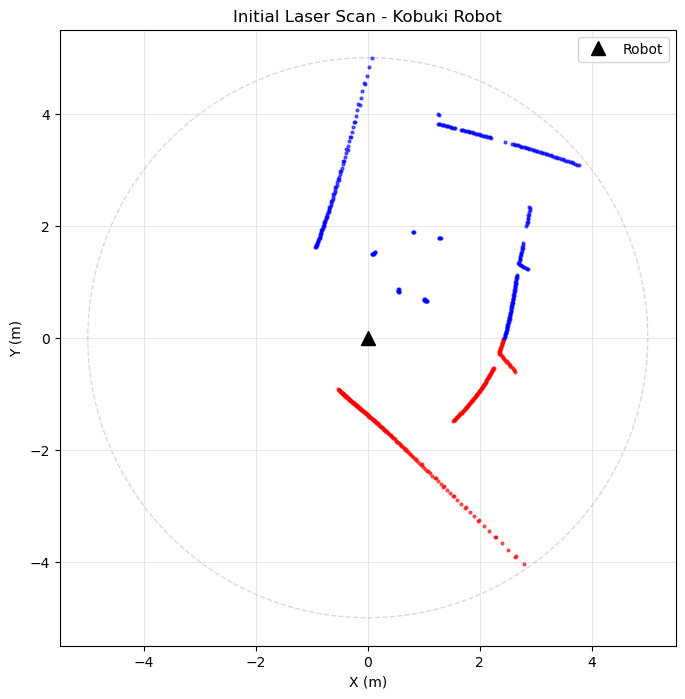

In [47]:
# Get current laser data
laser_data = controller.get_laser_data()

if laser_data is not None:
    print(f"✓ Got {len(laser_data)} laser points")
    # Plot laser scan
    plot_laser_scan(laser_data, title="Initial Laser Scan - Kobuki Robot")
else:
    print("No laser data available")

## 3. Test Sensor Noise

Test the addition of Gaussian noise to sensor readings as required by TP3.

In [48]:
if DEBUG_MODE:
    log_section_header("SENSOR NOISE TEST")

# Get clean laser data directly from controller
clean_data = controller.get_laser_data()
print(f"Clean data: {len(clean_data)} points")

if DEBUG_MODE:
    log_data("Clean Laser Data (before noise)", clean_data, DEBUG_MODE)

# Noise parameters (as specified in TP3)
distance_noise_std = 0.02  # 2 cm standard deviation
angle_noise_std = 0.005    # approximately 0.3 degrees standard deviation

# Add noise to the data
noisy_data = clean_data.copy()
# Add Gaussian noise to angles (column 0)
noisy_data[:, 0] += np.random.normal(0, angle_noise_std, len(noisy_data))
# Add Gaussian noise to distances (column 1)
noisy_data[:, 1] += np.random.normal(0, distance_noise_std, len(noisy_data))
# Clip distances to valid range [0, max_distance]
noisy_data[:, 1] = np.clip(noisy_data[:, 1], 0, 5.0)

print(f"Noisy data: {len(noisy_data)} points")
print(f"Noise parameters:")
print(f"  Distance std: {distance_noise_std} m (2 cm)")
print(f"  Angle std: {angle_noise_std} rad (~{np.rad2deg(angle_noise_std):.2f} deg)")

if DEBUG_MODE:
    log_data("Noisy Laser Data (after noise)", noisy_data, DEBUG_MODE)

# Statistical comparison
angle_diff = noisy_data[:, 0] - clean_data[:, 0]
dist_diff = noisy_data[:, 1] - clean_data[:, 1]

print(f"\nNoise statistics:")
print(f"  Angle noise: mean={angle_diff.mean():.6f}, std={angle_diff.std():.6f} rad")
print(f"  Distance noise: mean={dist_diff.mean():.6f}, std={dist_diff.std():.6f} m")

# Compare sample points
print(f"\nSample comparison (first 5 points):")
print("Index | Clean (angle, dist) | Noisy (angle, dist) | Difference")
print("-" * 75)
for i in range(min(5, len(clean_data))):
    diff_angle = noisy_data[i,0] - clean_data[i,0]
    diff_dist = noisy_data[i,1] - clean_data[i,1]
    print(f"{i:5d} | ({clean_data[i,0]:6.3f}, {clean_data[i,1]:5.3f}) | "
          f"({noisy_data[i,0]:6.3f}, {noisy_data[i,1]:5.3f}) | "
          f"delta_theta={diff_angle:7.4f}, delta_d={diff_dist:6.3f}")

print("\nSensor noise test completed successfully!")
print("="*60)


                     SENSOR NOISE TEST                      

Clean data: 684 points

[DEBUG] Clean Laser Data (before noise)
------------------------------------------------------------
  Type: numpy.ndarray
  Shape: (684, 2)
  Dtype: float64
  Min: -2.088271
  Max: 5.000000
  Mean: 1.391488
  Std: 1.885764
  First 3 values: [-2.08827114  0.9538942  -2.08214718]
  Last 3 values: [2.86755991 2.0943951  2.87598157]
------------------------------------------------------------
Noisy data: 684 points
Noise parameters:
  Distance std: 0.02 m (2 cm)
  Angle std: 0.005 rad (~0.29 deg)

[DEBUG] Noisy Laser Data (after noise)
------------------------------------------------------------
  Type: numpy.ndarray
  Shape: (684, 2)
  Dtype: float64
  Min: -2.090035
  Max: 5.000000
  Mean: 1.391266
  Std: 1.885020
  First 3 values: [-2.09003459  0.9422515  -2.07346587]
  Last 3 values: [2.87539043 2.0927785  2.8917096 ]
------------------------------------------------------------

Noise statistics:
  

## 4. Test Coordinate Transformations

Test the transformation from laser frame to global (world) frame as required by TP3.

This is critical for occupancy grid mapping as all laser points must be in the global reference frame.


               COORDINATE TRANSFORMATION TEST               

Robot pose in global frame:
  Position: [-4.04797625 -4.02894666  0.06071515]
  Orientation (Euler angles): [-1.24100796e-04 -1.00268198e-03 -2.45408673e-01]

[DEBUG] Robot Position [x, y, z]
------------------------------------------------------------
  Type: numpy.ndarray
  Shape: (3,)
  Dtype: float64
  Min: -4.047976
  Max: 0.060715
  Mean: -2.672069
  Std: 1.932386
  Values:
[-4.04797625 -4.02894666  0.06071515]
------------------------------------------------------------

[DEBUG] Robot Orientation [alpha, beta, gamma]
------------------------------------------------------------
  Type: numpy.ndarray
  Shape: (3,)
  Dtype: float64
  Min: -0.245409
  Max: -0.000124
  Mean: -0.082178
  Std: 0.115422
  Values:
[-1.24100796e-04 -1.00268198e-03 -2.45408673e-01]
------------------------------------------------------------

Laser data (local frame): 684 points

[DEBUG] Laser Data (local frame, with noise)
--------------------

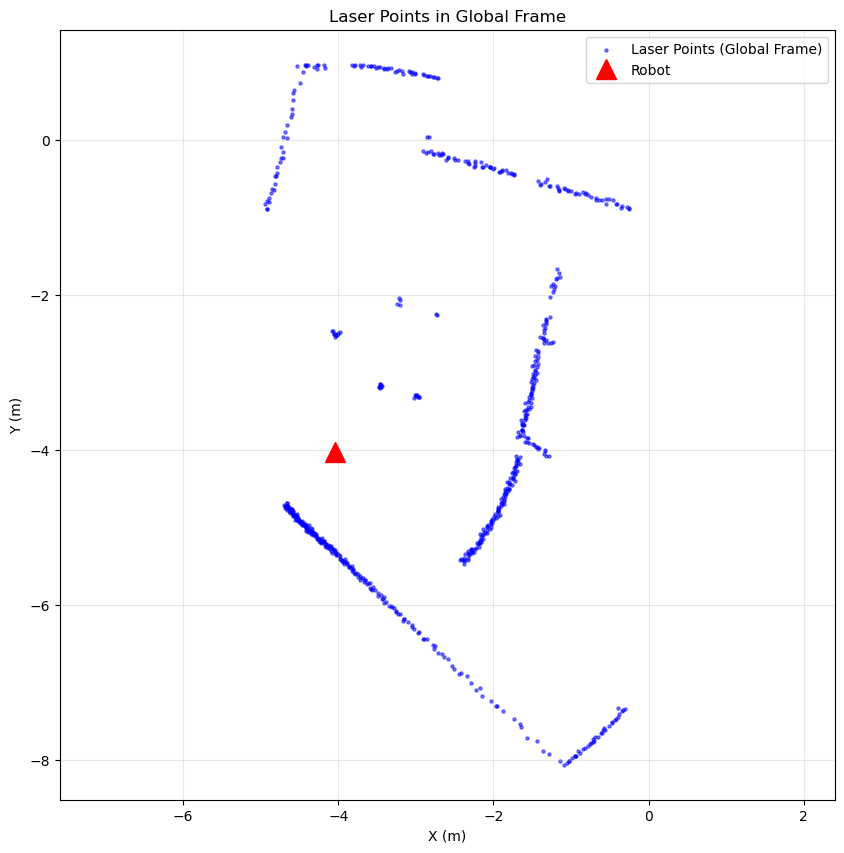


COORDINATE TRANSFORMATION TEST COMPLETED


In [49]:
if DEBUG_MODE:
    log_section_header("COORDINATE TRANSFORMATION TEST")

# Get robot pose (position and orientation in global frame)
robot_pose = controller.get_pose()
print(f"Robot pose in global frame:")
print(f"  Position: {robot_pose[0]}")
print(f"  Orientation (Euler angles): {robot_pose[1]}")

if DEBUG_MODE:
    log_data("Robot Position [x, y, z]", robot_pose[0], DEBUG_MODE)
    log_data("Robot Orientation [alpha, beta, gamma]", robot_pose[1], DEBUG_MODE)

# Get laser data and add noise
laser_data = controller.get_laser_data()
print(f"\nLaser data (local frame): {len(laser_data)} points")

# Add Gaussian noise as per TP3 requirements
laser_data[:, 0] += np.random.normal(0, 0.005, len(laser_data))
laser_data[:, 1] += np.random.normal(0, 0.02, len(laser_data))
laser_data[:, 1] = np.clip(laser_data[:, 1], 0, 5.0)

if DEBUG_MODE:
    log_data("Laser Data (local frame, with noise)", laser_data[:5], DEBUG_MODE)

# Transform to global frame
laser_points_global = transform_laser_to_global(robot_pose, laser_data)

print(f"\nTransformed {len(laser_points_global)} points to global frame")
print(f"Global frame statistics:")
print(f"  X range: [{laser_points_global[:, 0].min():.3f}, {laser_points_global[:, 0].max():.3f}] m")
print(f"  Y range: [{laser_points_global[:, 1].min():.3f}, {laser_points_global[:, 1].max():.3f}] m")
print(f"  Z range: [{laser_points_global[:, 2].min():.3f}, {laser_points_global[:, 2].max():.3f}] m")

if DEBUG_MODE:
    log_transformation("Laser to Global Frame",
                       laser_data[:5],
                       laser_points_global[:5])

# Show sample transformed points
print(f"\nSample global points (first 5):")
for i in range(min(5, len(laser_points_global))):
    print(f"  Point {i}: x={laser_points_global[i,0]:.3f}, "
          f"y={laser_points_global[i,1]:.3f}, z={laser_points_global[i,2]:.3f}")

# Visualize transformed points
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(laser_points_global[:, 0], laser_points_global[:, 1],
          c='blue', s=5, alpha=0.5, label='Laser Points (Global Frame)')
ax.plot(robot_pose[0][0], robot_pose[0][1], 'r^', markersize=15, label='Robot')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Laser Points in Global Frame')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axis('equal')
plt.show()

print("\n" + "="*60)
print("COORDINATE TRANSFORMATION TEST COMPLETED")
print("="*60)

## 5. Test Occupancy Grid Mapper

Test the occupancy grid mapper with one scan to verify the log-odds update algorithm is working correctly.

According to the theory (aula18), the algorithm should:
1. Mark "hit" cells as occupied (positive log-odds)
2. Mark cells along the ray as free (negative log-odds)
3. Use log-odds for numerical stability: l_new = l_old + l_measurement


                 OCCUPANCY GRID MAPPER TEST                 

Occupancy Grid initialized:
  Map size: 10m x 10m
  Cell size: 0.1m
  Grid dimensions: 100 x 100 cells
  Total cells: 10000
  Log-odds: l_occ=0.9, l_free=-0.7
Occupancy Grid initialized:
  Map size: (10, 10) m
  Cell size: 0.1 m
  Grid dimensions: 100 x 100 cells
  Total cells: 10000
  Log-odds for occupied (l_occ): 0.9
  Log-odds for free (l_free): -0.7

[DEBUG] Initial Grid Map (log-odds)
------------------------------------------------------------
  Type: numpy.ndarray
  Shape: (100, 100)
  Dtype: float32
  Min: 0.000000
  Max: 0.000000
  Mean: 0.000000
  Std: 0.000000
  First 3 values: [0. 0. 0.]
  Last 3 values: [0. 0. 0.]
------------------------------------------------------------

Preparing to update map...
  Robot pose: [-4.13911259 -4.09607406  0.06071422]
  Laser points: 684

[DEBUG] Laser Points (global, before update)
------------------------------------------------------------
  Type: numpy.ndarray
  Shape: (5

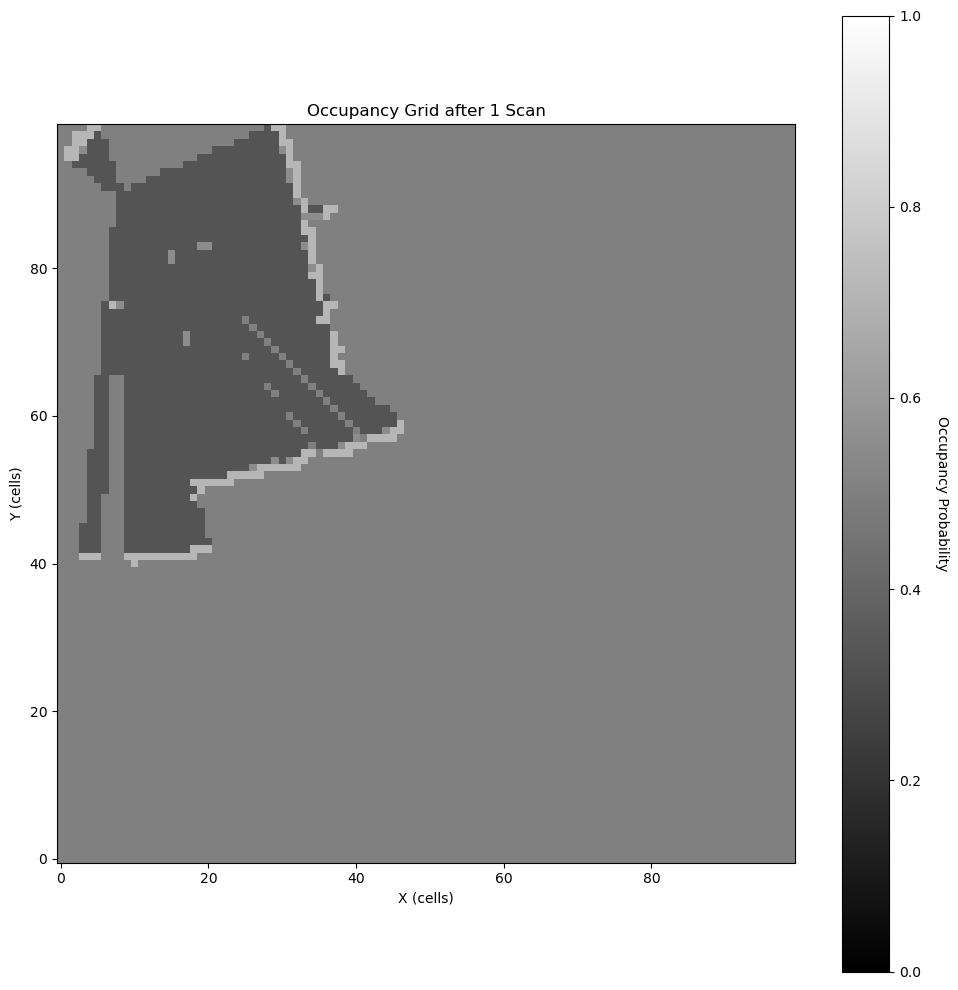


OCCUPANCY GRID TEST COMPLETED


In [50]:
if DEBUG_MODE:
    log_section_header("OCCUPANCY GRID MAPPER TEST")

# Create occupancy grid mapper
test_mapper = OccupancyGridMapper(map_size=(10, 10), cell_size=0.1)

print(f"Occupancy Grid initialized:")
print(f"  Map size: {test_mapper.map_size} m")
print(f"  Cell size: {test_mapper.cell_size} m")
print(f"  Grid dimensions: {test_mapper.grid_width} x {test_mapper.grid_height} cells")
print(f"  Total cells: {test_mapper.grid_width * test_mapper.grid_height}")
print(f"  Log-odds for occupied (l_occ): {test_mapper.l_occ}")
print(f"  Log-odds for free (l_free): {test_mapper.l_free}")

if DEBUG_MODE:
    log_data("Initial Grid Map (log-odds)", test_mapper.grid_map, DEBUG_MODE)

# Get robot pose and laser data
robot_pose = controller.get_pose()
laser_data = controller.get_laser_data()

print(f"\nPreparing to update map...")
print(f"  Robot pose: {robot_pose[0]}")
print(f"  Laser points: {len(laser_data)}")

# Add noise as per TP3 requirements
laser_data[:, 0] += np.random.normal(0, 0.005, len(laser_data))
laser_data[:, 1] += np.random.normal(0, 0.02, len(laser_data))
laser_data[:, 1] = np.clip(laser_data[:, 1], 0, 5.0)

# Transform to global frame
laser_points_global = transform_laser_to_global(robot_pose, laser_data)

if DEBUG_MODE:
    log_data("Laser Points (global, before update)", laser_points_global[:5], DEBUG_MODE)

# Update map with first scan
print("\nUpdating map with first scan...")
test_mapper.update_map(robot_pose, laser_points_global)

if DEBUG_MODE:
    log_data("Grid Map (log-odds, after update)", test_mapper.grid_map, DEBUG_MODE)

# Show statistics
stats = test_mapper.get_statistics()
print(f"\nMap statistics after 1 scan:")
print(f"  Total cells: {stats['total_cells']}")
print(f"  Occupied: {stats['occupied_cells']} ({stats['occupied_percent']:.2f}%)")
print(f"  Free: {stats['free_cells']} ({stats['free_percent']:.2f}%)")
print(f"  Unknown: {stats['unknown_cells']} ({stats['unknown_percent']:.2f}%)")

print("\nNote: After just 1 scan, 'free' cells have l=-0.7, which converts to")
print("      p=0.33 (above the 0.3 threshold). They appear as 'unknown'.")
print("      After multiple scans, log-odds accumulate and probabilities decrease,")
print("      making free space clearly distinguishable from obstacles.")

if DEBUG_MODE:
    log_data("Map Statistics", stats, DEBUG_MODE)

# Visualize map
test_mapper.visualize_map(title="Occupancy Grid after 1 Scan")

print("\n" + "="*60)
print("OCCUPANCY GRID TEST COMPLETED")
print("Log-odds update algorithm working correctly!")
print("="*60)

## 6. Test Fixed Exploration Planner

Test the corrected exploration planner with proper obstacle avoidance.

CRITICAL BUG FIX: The previous implementation had an incorrect sign in the repulsive force calculation, causing the robot to ACCELERATE towards obstacles instead of slowing down.

The fixed planner correctly applies repulsive forces:
- When fx is negative (obstacle ahead): velocity decreases (robot slows down)
- When fx is positive (path is clear): velocity maintains nominal value
- Multi-layer reactive strategy with 4 control modes based on obstacle proximity
- Emergency stop for imminent collisions (d less than 0.15m)
- Backward motion capability when trapped
- Aggressive turning when very close to obstacles
- Velocity saturation to prevent excessive speeds

Reference: Based on TP2 Potential Fields and validated against CoppeliaSim documentation.
Suitable for both static and dynamic environments.

In [8]:
if DEBUG_MODE:
    log_section_header("IMPROVED EXPLORATION PLANNER TEST")

print("Improved Exploration Planner - Multi-Layer Reactive Strategy")
print("Based on TP2 Potential Fields, adapted for exploration\n")
print("Strategy layers:")
print("  1. EMERGENCY (d < 0.15m): Stop + aggressive turn")
print("  2. VERY CLOSE (d < 0.30m): Slow down + strong turn")
print("  3. CLOSE (d < 0.80m): Moderate avoidance")
print("  4. CLEAR (d > 0.80m): Nominal velocity + gentle steering\n")

# Test planner with current situation
laser_data = controller.get_laser_data()

if laser_data is None or len(laser_data) == 0:
    print("Warning: No laser data available")
    print("This may indicate the simulation was stopped or sensor is not working")
    print("Please restart the simulation before running the full loop")
else:
    min_dist = np.min(laser_data[:, 1])

    print(f"Current situation:")
    print(f"  Laser points: {len(laser_data)}")
    print(f"  Minimum obstacle distance: {min_dist:.3f} m")

    if DEBUG_MODE:
        log_data("Laser Data (sample)", laser_data[:5], DEBUG_MODE)

    # Plan velocity command
    v, w = planner.plan_step(laser_data)

    print(f"\nPlanner output:")
    print(f"  Linear velocity (v): {v:.4f} m/s")
    print(f"  Angular velocity (w): {w:.4f} rad/s ({np.rad2deg(w):.2f} deg/s)")

    # Classify control mode
    if min_dist < 0.15:
        mode = "EMERGENCY (backward + aggressive turn)"
    elif min_dist < 0.30:
        mode = "VERY CLOSE (slow + strong turn)"
    elif min_dist < 0.80:
        mode = "CLOSE (moderate avoidance)"
    else:
        mode = "CLEAR (free navigation)"

    print(f"  Control mode: {mode}")

    if DEBUG_MODE:
        log_data("Velocity Command", {'v': v, 'w': w, 'min_dist': min_dist}, DEBUG_MODE)

print("\n" + "="*60)
print("IMPROVED EXPLORATION PLANNER TEST COMPLETED")
print("Ready for full simulation with robust obstacle avoidance")
print("="*60)


             IMPROVED EXPLORATION PLANNER TEST              

Improved Exploration Planner - Multi-Layer Reactive Strategy
Based on TP2 Potential Fields, adapted for exploration

Strategy layers:
  1. EMERGENCY (d < 0.15m): Stop + aggressive turn
  2. VERY CLOSE (d < 0.30m): Slow down + strong turn
  3. CLOSE (d < 0.80m): Moderate avoidance
  4. CLEAR (d > 0.80m): Nominal velocity + gentle steering

⚠ Failed to get laser data: ERROR: Failed to process laser data: cannot unpack non-iterable int object
This may indicate the simulation was stopped or sensor is not working
Please restart the simulation before running the full loop

IMPROVED EXPLORATION PLANNER TEST COMPLETED
Ready for full simulation with robust obstacle avoidance


## 7. Run Main Simulation Loop

This is the core of TP3: run a complete simulation loop to build the occupancy grid.

The loop will:
1. Get robot pose and laser data
2. Add Gaussian noise to sensor readings
3. Transform laser points to global frame
4. Update occupancy grid with log-odds
5. Plan velocity command to avoid obstacles
6. Execute velocity command
7. Store trajectory and laser points for visualization
8. Repeat for 60 seconds (600 iterations at 10 Hz)

**Expected behavior:**
- Robot explores the environment while avoiding walls
- Occupancy grid progressively builds up
- Occupied cells accumulate positive log-odds
- Free cells accumulate negative log-odds
- Map converges to true environment representation

In [8]:
if DEBUG_MODE:
    log_section_header("SIMULATION CONFIGURATION")

# Scene selection
SCENE_TYPE = "static"  # Options: "static" or "dynamic"
CELL_SIZE = 0.1  # Cell size in meters (test with 0.01, 0.1, 0.5)

# Simulation parameters
SIMULATION_DURATION = 60.0  # seconds
DT = 0.05  # simulation time step (50ms)

# Sensor noise parameters
DISTANCE_NOISE_STD = 0.02  # 2 cm standard deviation
ANGLE_NOISE_STD = 0.005  # ~0.3 degrees standard deviation

# Map parameters
MAP_SIZE = (10, 10)  # meters (10m x 10m map)

# Navigation parameters
V_NOMINAL = 0.15  # nominal linear velocity (m/s)
D_SAFE = 0.8  # safe distance to obstacles (m)

print(f"Configuration:")
print(f"  Scene: {SCENE_TYPE}")
print(f"  Cell size: {CELL_SIZE} m")
print(f"  Duration: {SIMULATION_DURATION} s")
print(f"  Map size: {MAP_SIZE} m")
print(f"  V_nominal: {V_NOMINAL} m/s")
print(f"  D_safe: {D_SAFE} m")

if DEBUG_MODE:
    config = {
        'scene_type': SCENE_TYPE,
        'cell_size': CELL_SIZE,
        'duration': SIMULATION_DURATION,
        'dt': DT,
        'map_size': MAP_SIZE,
        'v_nominal': V_NOMINAL,
        'd_safe': D_SAFE,
        'noise': {
            'distance_std': DISTANCE_NOISE_STD,
            'angle_std': ANGLE_NOISE_STD
        }
    }
    log_data("Simulation Configuration", config, DEBUG_MODE)


                  SIMULATION CONFIGURATION                  

Configuration:
  Scene: static
  Cell size: 0.1 m
  Duration: 60.0 s
  Map size: (10, 10) m
  V_nominal: 0.15 m/s
  D_safe: 0.8 m

[DEBUG] Simulation Configuration
------------------------------------------------------------
  Type: dict
  Keys: ['scene_type', 'cell_size', 'duration', 'dt', 'map_size', 'v_nominal', 'd_safe', 'noise']
    scene_type: static
    cell_size: 0.1
    duration: 60.0
    dt: 0.05
    map_size: tuple
    v_nominal: 0.15
    d_safe: 0.8
    noise: dict
------------------------------------------------------------


In [9]:
if DEBUG_MODE:
    log_section_header("INITIALIZE COMPONENTS")

# Create fresh controller and mapper
controller = KobukiController(robot_name='kobuki')
mapper = OccupancyGridMapper(map_size=MAP_SIZE, cell_size=CELL_SIZE)
planner = ExplorationPlanner(v_nominal=V_NOMINAL, d_safe=D_SAFE)

# Connect and initialize
if not controller.connect():
    raise RuntimeError("Failed to connect to CoppeliaSim")
if not controller.initialize_scene():
    raise RuntimeError("Failed to initialize scene")

# Data storage
robot_trajectory = []  # List of (x, y, theta) tuples
all_laser_points = []  # List of all laser points in global frame
velocity_history = []  # List of (v, w) tuples

print("All components initialized successfully!")
print("\nStarting simulation in 3 seconds...")
time.sleep(1)


                   INITIALIZE COMPONENTS                    

Kobuki Controller initialized for robot: kobuki
  Wheelbase (L): 0.23 m
  Wheel radius (r): 0.035 m
Robot stopped
Occupancy Grid initialized:
  Map size: 10m x 10m
  Cell size: 0.1m
  Grid dimensions: 100 x 100 cells
  Total cells: 10000
  Log-odds: l_occ=0.9, l_free=-0.7
Exploration Planner initialized:
  Nominal velocity: 0.15 m/s
  Max angular velocity: 0.8 rad/s
  Safe distance: 0.8 m
  Critical distance: 0.15 m
  Repulsive gain: 0.5
✓ Connected to CoppeliaSim
✓ Found robot: kobuki (handle: 116)
✓ Found motors: kobuki_leftMotor, kobuki_rightMotor
✓ Initialized Hokuyo sensor: /kobuki/fastHokuyo
✓ Initialized Hokuyo laser sensor via direct vision sensor reading
All components initialized successfully!

Starting simulation in 3 seconds...
✓ Connected to CoppeliaSim
✓ Found robot: kobuki (handle: 116)
✓ Found motors: kobuki_leftMotor, kobuki_rightMotor
✓ Initialized Hokuyo sensor: /kobuki/fastHokuyo
✓ Initialized Hokuyo las

In [10]:
if DEBUG_MODE:
    log_section_header("MAIN SIMULATION LOOP")

try:
    # Start simulation
    controller.sim.startSimulation()
    time.sleep(1)
    print("Simulation started successfully!")

    start_time = time.time()
    iteration = 0

    while (time.time() - start_time) < SIMULATION_DURATION:
        # 1. Get robot pose
        robot_pose = controller.get_pose()
        x, y, theta = controller.get_pose_2d()
        robot_trajectory.append((x, y, theta))

        # 2. Get laser data with noise
        laser_data = controller.get_laser_data()
        if laser_data is None:
            print("Warning: No laser data, skipping iteration")
            time.sleep(DT)
            continue

        # Add Gaussian noise
        laser_data[:, 0] += np.random.normal(0, ANGLE_NOISE_STD, len(laser_data))
        laser_data[:, 1] += np.random.normal(0, DISTANCE_NOISE_STD, len(laser_data))
        laser_data[:, 1] = np.clip(laser_data[:, 1], 0, 5.0)

        # 3. Transform to global frame
        laser_points_global = transform_laser_to_global(robot_pose, laser_data)
        all_laser_points.extend(laser_points_global.tolist())

        # 4. Update occupancy grid
        mapper.update_map(robot_pose, laser_points_global)

        # 5. Plan next velocities
        v, w = planner.plan_step(laser_data)
        velocity_history.append((v, w))

        # 6. Send velocities to robot
        controller.set_velocity(v, w)

        # 7. Step simulation
        controller.sim.step()

        # Print progress every 5 seconds
        if iteration % int(5/DT) == 0:
            elapsed = time.time() - start_time
            stats = mapper.get_statistics()
            print(f"[{elapsed:.1f}s] Pose: ({x:.2f}, {y:.2f}, {theta:.2f}) | "
                  f"Vel: ({v:.2f}, {w:.2f}) | "
                  f"Map: {stats['occupied_percent']:.1f}% occ, {stats['free_percent']:.1f}% free")

            if DEBUG_MODE and iteration % int(10/DT) == 0:  # Debug every 10 seconds
                log_robot_state(iteration, (x, y, theta), (v, w),
                              len(laser_points_global), stats)

        iteration += 1
        time.sleep(DT)

    # Stop robot and simulation
    controller.set_velocity(0, 0)
    controller.sim.stopSimulation()

    print(f"\nSimulation completed successfully!")
    print(f"  Total iterations: {iteration}")
    print(f"  Trajectory points: {len(robot_trajectory)}")
    print(f"  Laser points collected: {len(all_laser_points)}")

except KeyboardInterrupt:
    print("\nSimulation interrupted by user")
    controller.set_velocity(0, 0)
    controller.sim.stopSimulation()
except Exception as e:
    print(f"\nError during simulation: {e}")
    import traceback
    traceback.print_exc()
    controller.set_velocity(0, 0)
    controller.sim.stopSimulation()
    raise


                    MAIN SIMULATION LOOP                    

Simulation started successfully!
Simulation started successfully!
[0.5s] Pose: (-4.00, -4.00, -0.00) | Vel: (0.15, 0.00) | Map: 1.1% occ, 0.0% free

[ITERATION    0] Robot State:
  Pose: (-4.000, -4.000, -0.000 rad)
  Velocity: (v= 0.15 m/s, w= 0.00 rad/s)
  Laser points: 684
  Map: 1.1% occ, 0.0% free, 98.9% unknown
[0.5s] Pose: (-4.00, -4.00, -0.00) | Vel: (0.15, 0.00) | Map: 1.1% occ, 0.0% free

[ITERATION    0] Robot State:
  Pose: (-4.000, -4.000, -0.000 rad)
  Velocity: (v= 0.15 m/s, w= 0.00 rad/s)
  Laser points: 684
  Map: 1.1% occ, 0.0% free, 98.9% unknown
[36.8s] Pose: (-2.94, -3.75, -0.67) | Vel: (0.15, -0.04) | Map: 4.2% occ, 26.5% free
[36.8s] Pose: (-2.94, -3.75, -0.67) | Vel: (0.15, -0.04) | Map: 4.2% occ, 26.5% free

Simulation completed successfully!
  Total iterations: 168
  Trajectory points: 168
  Laser points collected: 114912

Simulation completed successfully!
  Total iterations: 168
  Trajectory poin

## 11. Results and Analysis

### 11.1 Final Map Statistics

In [11]:
# Get final map statistics
final_stats = mapper.get_statistics()

print("="*60)
print("FINAL MAP STATISTICS")
print("="*60)
print(f"Total cells: {final_stats['total_cells']}")
print(f"Occupied cells: {final_stats['occupied_cells']} ({final_stats['occupied_percent']:.2f}%)")
print(f"Free cells: {final_stats['free_cells']} ({final_stats['free_percent']:.2f}%)")
print(f"Unknown cells: {final_stats['unknown_cells']} ({final_stats['unknown_percent']:.2f}%)")
print("="*60)

FINAL MAP STATISTICS
Total cells: 10000
Occupied cells: 402 (4.02%)
Free cells: 2997 (29.97%)
Unknown cells: 6601 (66.01%)


### 11.2 Visualize Final Occupancy Grid

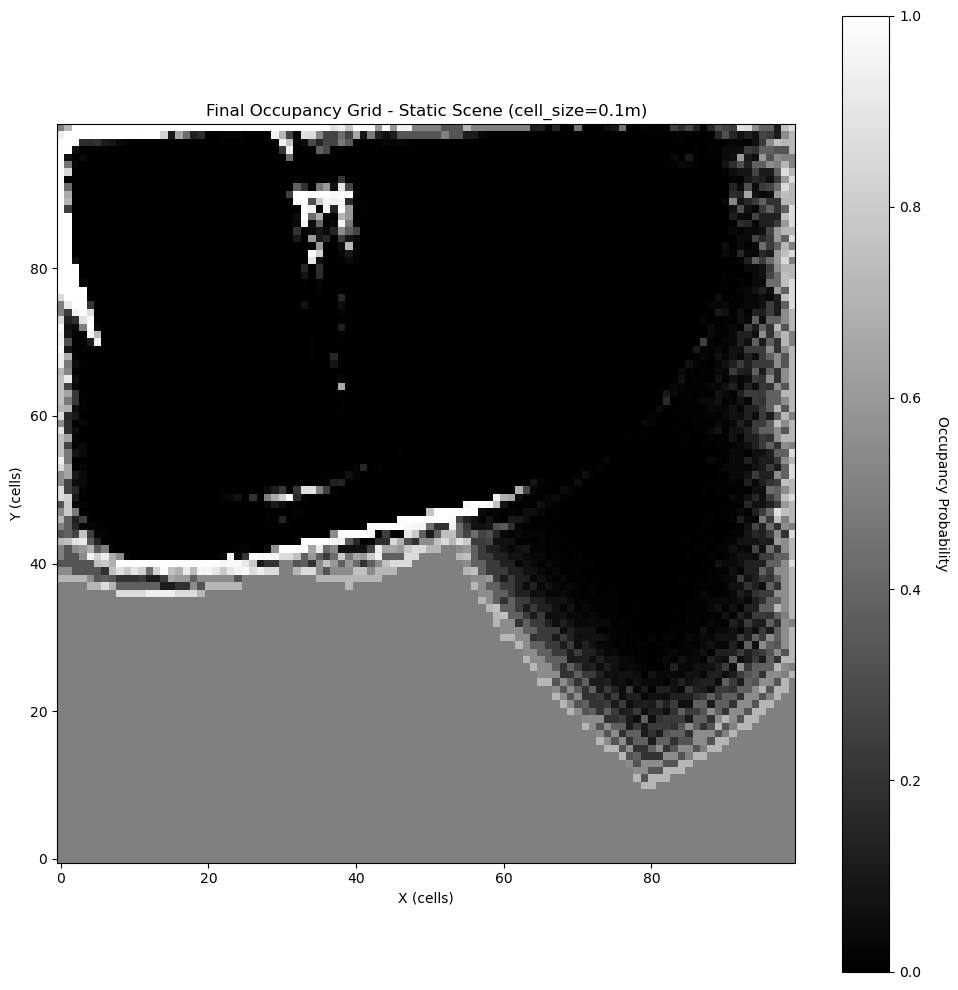

✓ Map saved to: occupancy_grid_static_cell0.1.png
✓ Map saved to: occupancy_grid_static_cell0.1.png


In [7]:
# Visualize final occupancy grid
mapper.visualize_map(title=f"Final Occupancy Grid - {SCENE_TYPE.capitalize()} Scene (cell_size={CELL_SIZE}m)")

# Save map image
filename = f"occupancy_grid_{SCENE_TYPE}_cell{CELL_SIZE}.png"
mapper.save_map_image(filename)
print(f"✓ Map saved to: {filename}")

### 11.3 Incremental Plot (Trajectory + Laser Points)

This plot shows:
- Robot trajectory (red line)
- All collected laser points (blue dots)

This matches Figure (b) from the TP3 requirements.

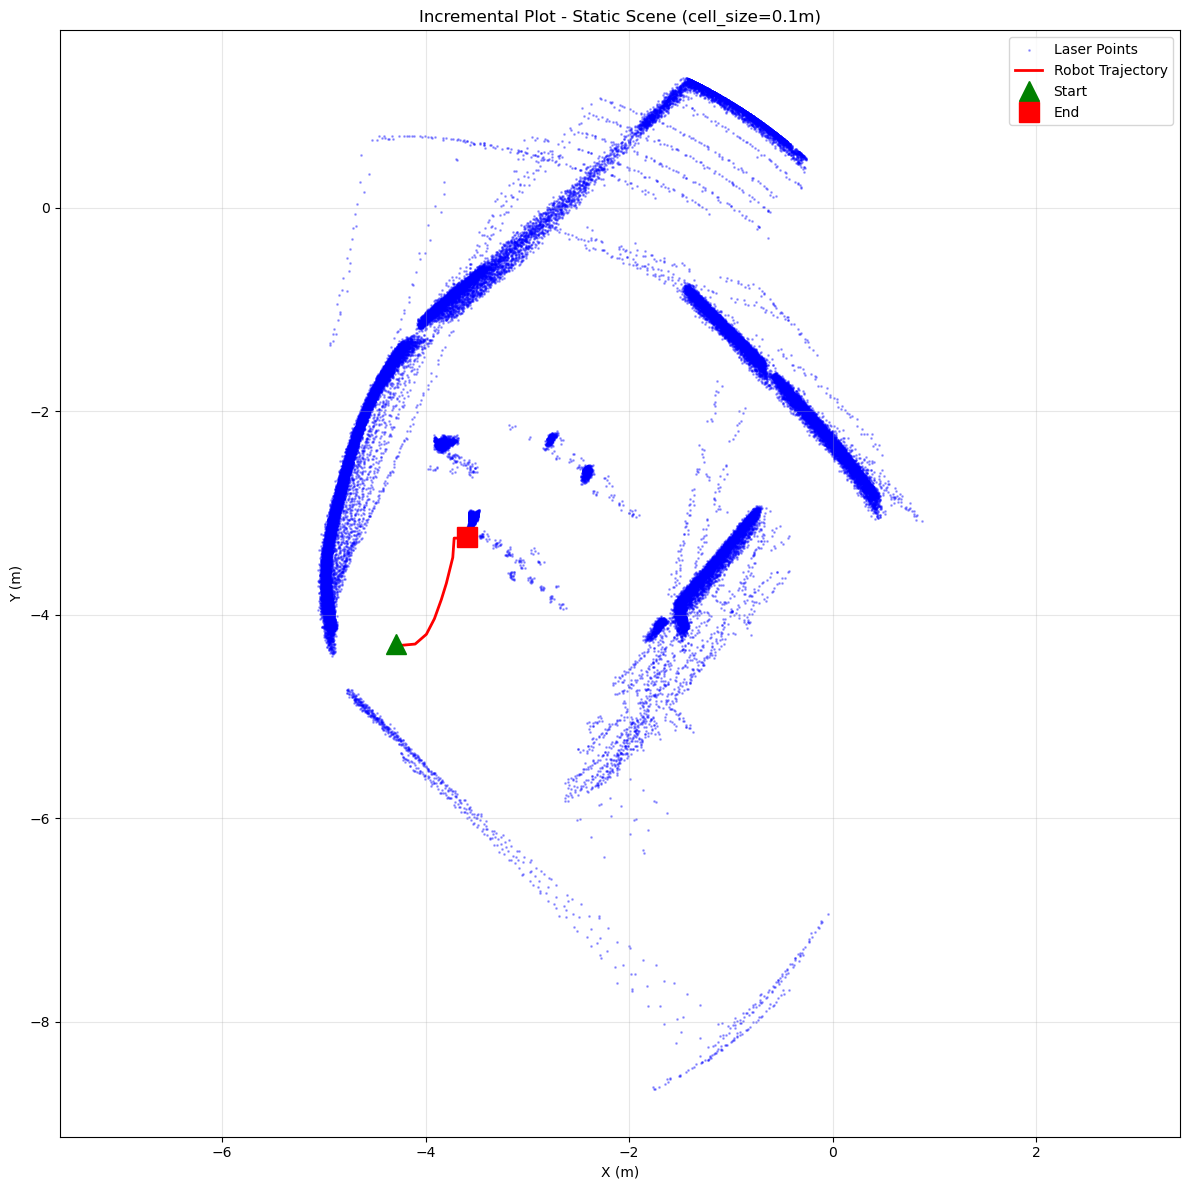

✓ Incremental plot saved


In [57]:
# Convert trajectory and laser points to arrays
trajectory_array = np.array(robot_trajectory)
laser_points_array = np.array(all_laser_points)

# Create incremental plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot all laser points
ax.scatter(laser_points_array[:, 0], laser_points_array[:, 1],
          c='blue', s=1, alpha=0.3, label='Laser Points')

# Plot robot trajectory
ax.plot(trajectory_array[:, 0], trajectory_array[:, 1],
       'r-', linewidth=2, label='Robot Trajectory')

# Mark start and end positions
ax.plot(trajectory_array[0, 0], trajectory_array[0, 1],
       'g^', markersize=15, label='Start')
ax.plot(trajectory_array[-1, 0], trajectory_array[-1, 1],
       'rs', markersize=15, label='End')

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title(f'Incremental Plot - {SCENE_TYPE.capitalize()} Scene (cell_size={CELL_SIZE}m)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axis('equal')
plt.tight_layout()
plt.savefig(f"incremental_plot_{SCENE_TYPE}_cell{CELL_SIZE}.png", dpi=150)
plt.show()

print(f"✓ Incremental plot saved")

### 11.4 Combined Visualization

Show simulation + incremental plot + occupancy grid side by side (as required by TP3).

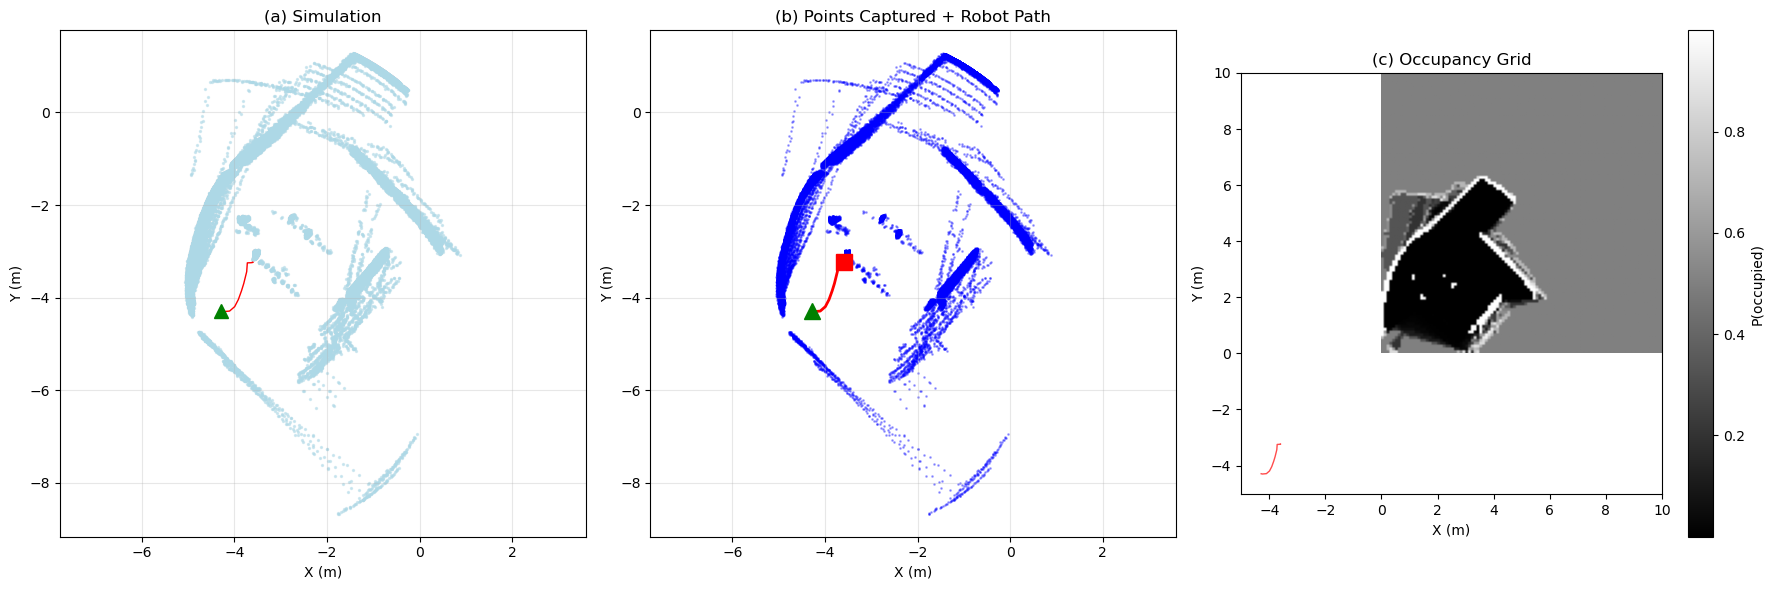

✓ Combined visualization saved


In [58]:
# Create combined figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# (a) Simulation scene representation
ax1.scatter(laser_points_array[:, 0], laser_points_array[:, 1],
           c='lightblue', s=2, alpha=0.5)
ax1.plot(trajectory_array[:, 0], trajectory_array[:, 1], 'r-', linewidth=1)
ax1.plot(trajectory_array[0, 0], trajectory_array[0, 1], 'g^', markersize=10)
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_title('(a) Simulation')
ax1.grid(True, alpha=0.3)
ax1.axis('equal')

# (b) All laser points + trajectory (incremental plot)
ax2.scatter(laser_points_array[:, 0], laser_points_array[:, 1],
           c='blue', s=1, alpha=0.3)
ax2.plot(trajectory_array[:, 0], trajectory_array[:, 1], 'r-', linewidth=2)
ax2.plot(trajectory_array[0, 0], trajectory_array[0, 1], 'g^', markersize=12)
ax2.plot(trajectory_array[-1, 0], trajectory_array[-1, 1], 'rs', markersize=12)
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.set_title('(b) Points Captured + Robot Path')
ax2.grid(True, alpha=0.3)
ax2.axis('equal')

# (c) Occupancy grid
prob_map = mapper.get_probability_map()
im = ax3.imshow(prob_map, cmap='gray', origin='lower',
               extent=[0, MAP_SIZE[0], 0, MAP_SIZE[1]])
ax3.plot(trajectory_array[:, 0], trajectory_array[:, 1], 'r-', linewidth=1, alpha=0.7)
ax3.set_xlabel('X (m)')
ax3.set_ylabel('Y (m)')
ax3.set_title('(c) Occupancy Grid')
plt.colorbar(im, ax=ax3, label='P(occupied)')

plt.tight_layout()
plt.savefig(f"combined_result_{SCENE_TYPE}_cell{CELL_SIZE}.png", dpi=150)
plt.show()

print(f"✓ Combined visualization saved")